In [1]:
import seaborn as sns
import pandas as pd
import missingno as msno
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Original

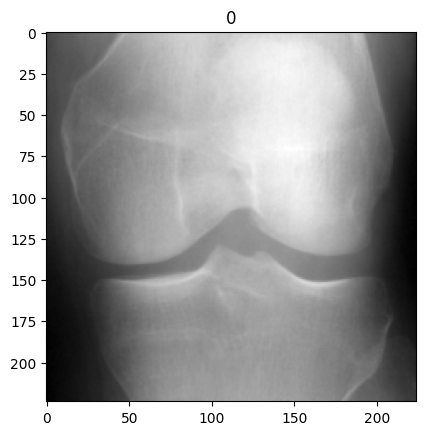

In [2]:
# data 경로 설정
data_dir = '../z20_data/datas/train/0'
categories = ['train','test','val'] # 전처리될 데이터셋을 훈련용, 테스트용, 검증용으로 구분

# 샘플 이미지 시각화
img_name = os.listdir(data_dir)[0]
img_path = os.path.join(data_dir, img_name)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f'0')
plt.show()

원하는 부위만 자르기 -> 자르고 다른 폴더에 다시 저장해야함

In [28]:
image = cv2.imread(img_path, cv2.IMREAD_COLOR)

start_x, start_y, width, height = 20,100,250,75
end_x, end_y = start_x + width, start_y + height
cropped_image = image[start_y:end_y, start_x:end_x]

# 이미지 저장
cv2.imwrite('imgs/img0.png', cropped_image)  # 저장할 폴더이름/저장할 파일명

cv2.imshow("Cropped Image", cropped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


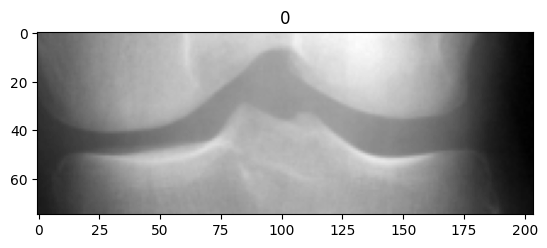

In [30]:
# data 경로 설정
data_dir = 'imgs'
categories = ['train','test','val'] # 전처리될 데이터셋을 훈련용, 테스트용, 검증용으로 구분

# 샘플 이미지 시각화
img_name = os.listdir(data_dir)[0]
img_path = os.path.join(data_dir, img_name)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f'0')
plt.show()

### Clahe(명암)

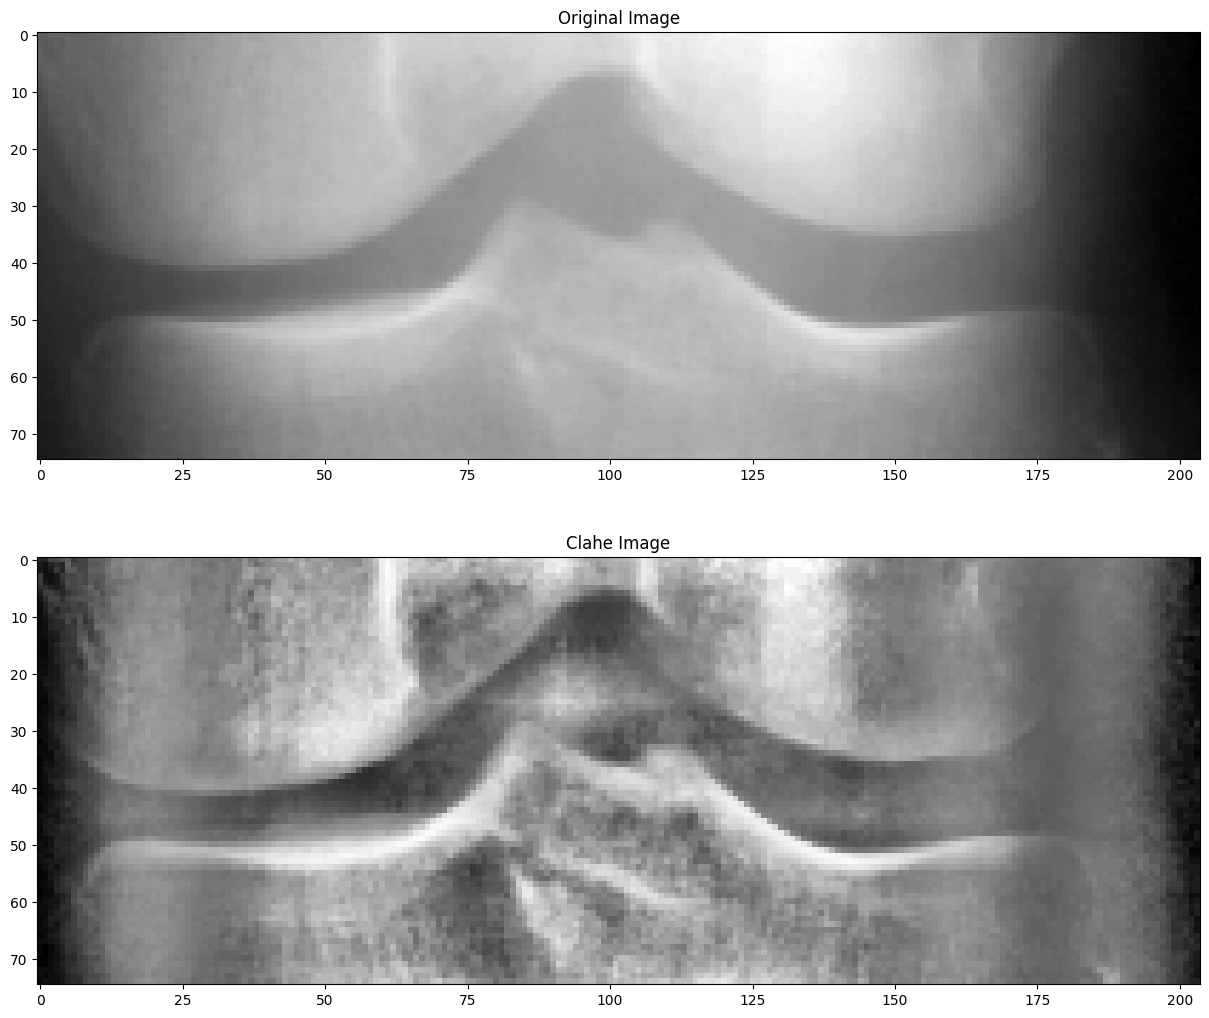

In [35]:
def clahe_img(img):
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
    cl_img = clahe.apply(img)
    return cl_img
    

plt.figure(figsize=(15, 25))
plt.subplot(2, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')


plt.subplot(1, 1, 1)
plt.imshow(clahe_img(img), cmap='gray')
plt.title('Clahe Image')
plt.show()

### Denoise(노이즈 제거)

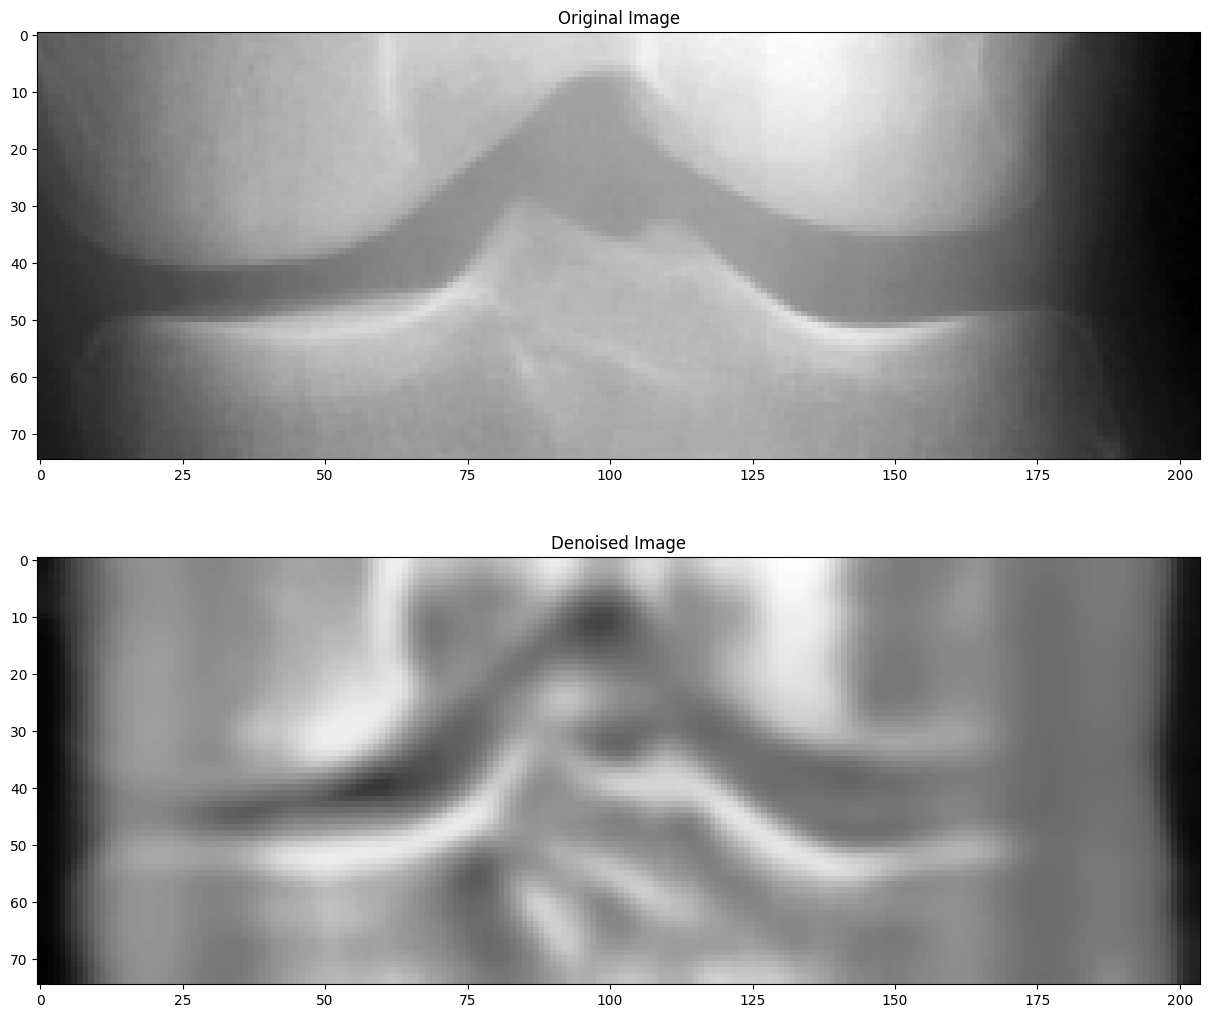

In [41]:
def denoise_img(img):
    return cv2.fastNlMeansDenoising(img, None, 30, 7, 210)

denoised_img = denoise_img(clahe_img(img))

plt.figure(figsize=(15, 25))
plt.subplot(2, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 1, 1)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image')
plt.show()

### Edge(외곽선 그리기)
- original img vs. denoised img
- 각 사진마다 param 값을 다르게 해서 함수 3개를 만들었음

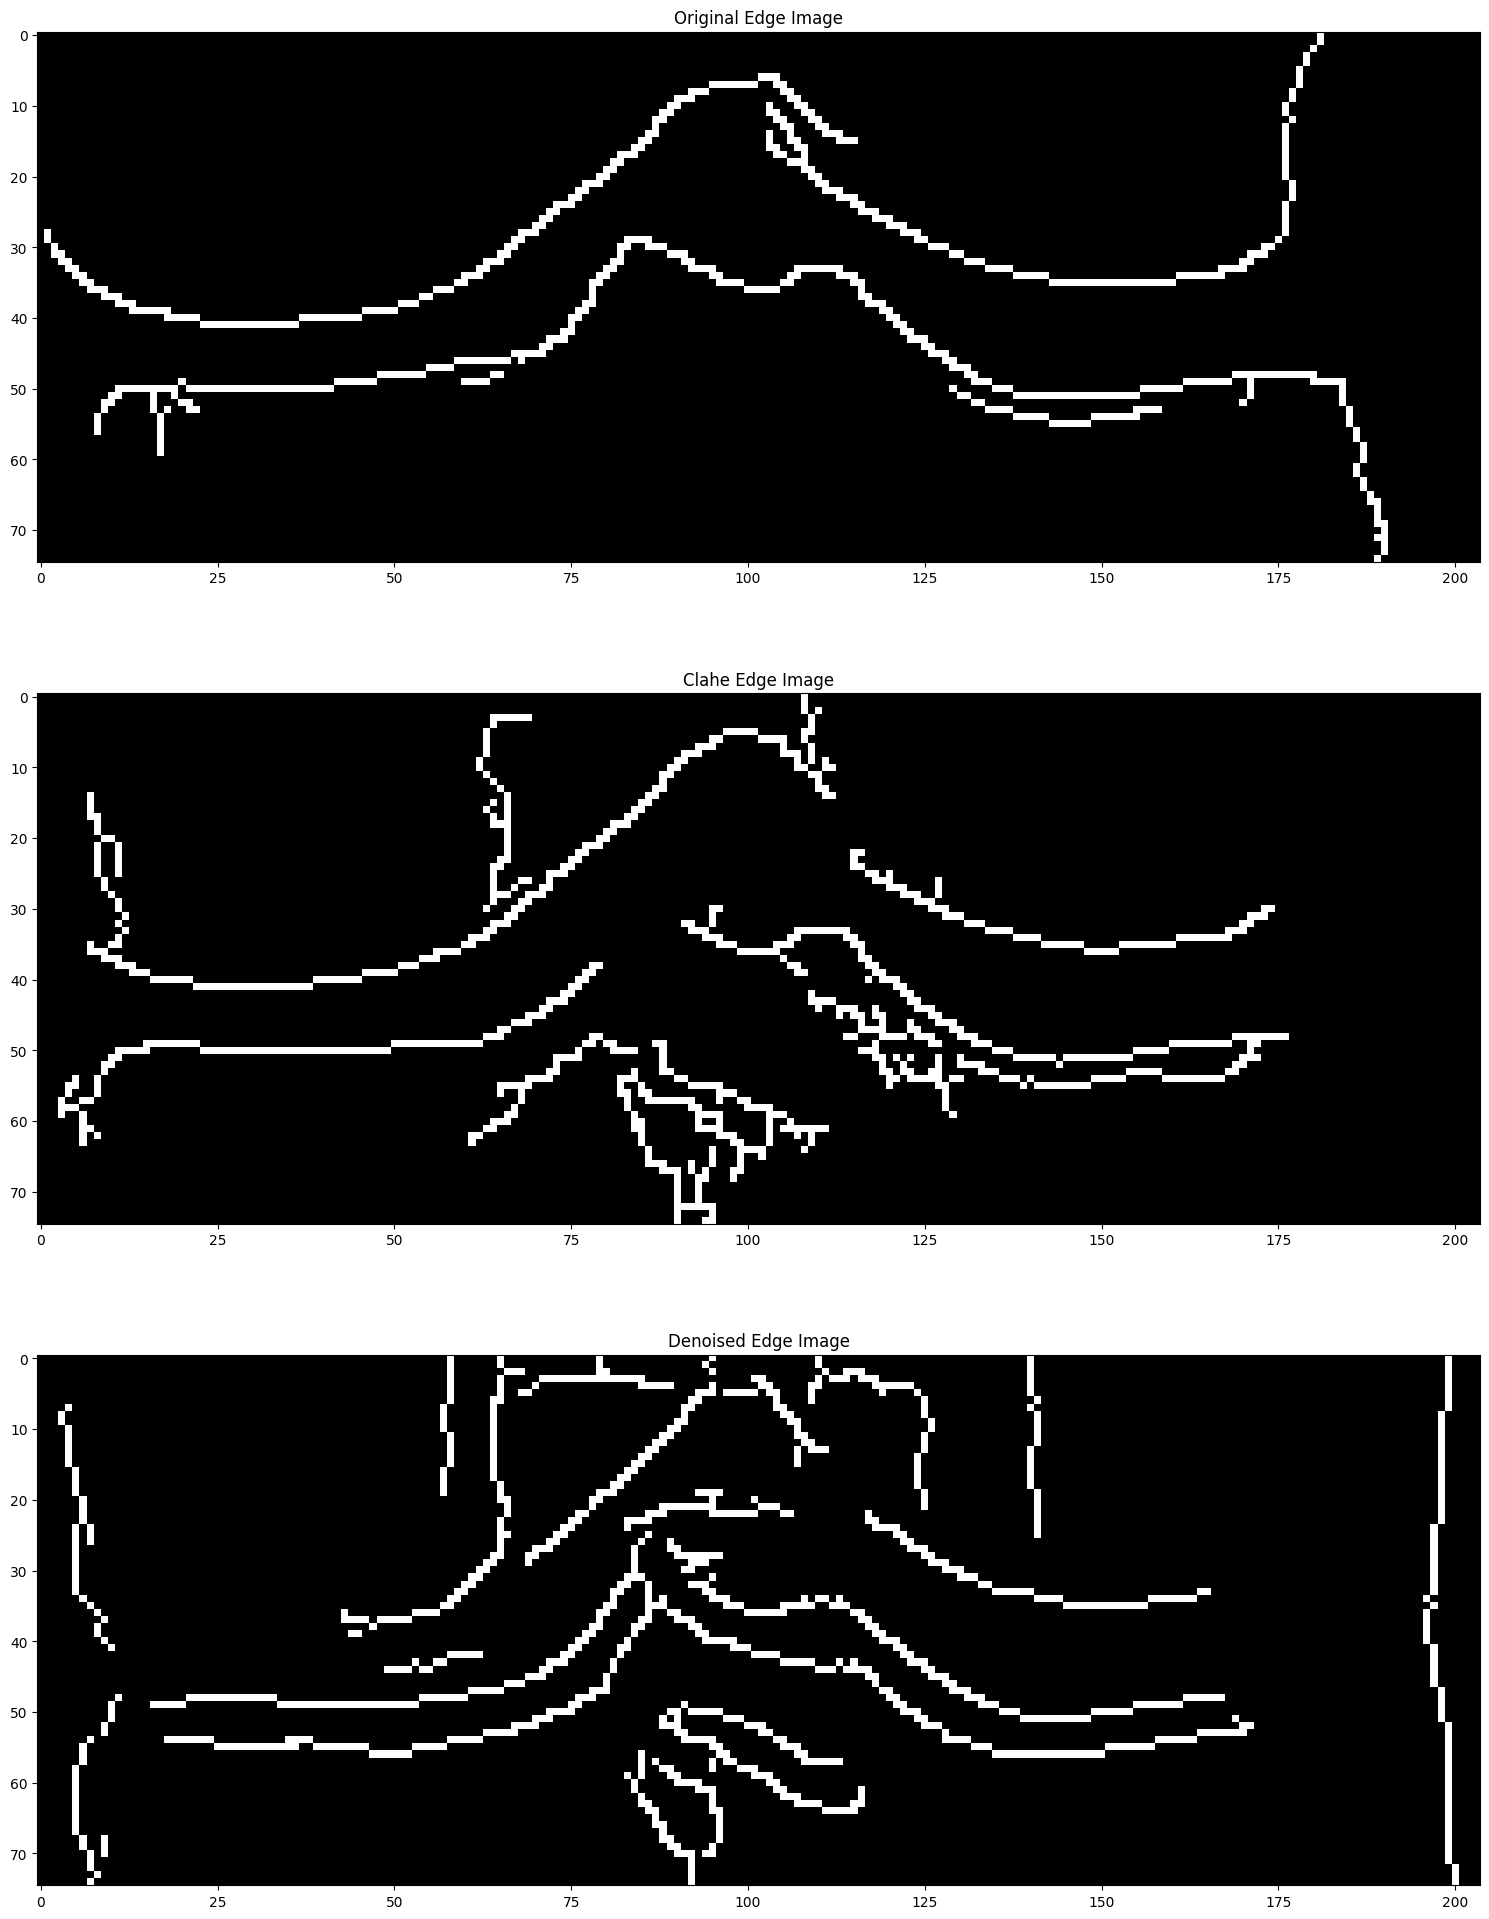

In [80]:
def det_edge_o(img):
    return cv2.Canny(img, 30, 100)  # 값을 조절해주면 선을 그리는 범위가 달라짐

orginal_edge_img = det_edge_o(img)

def det_edge_c(img):
    return cv2.Canny(img, 430, 100)
clahe_edge_img = det_edge_c(clahe_img(img))

def det_edge_d(img):
    return cv2.Canny(img, 30, 100)
denoised_edge_img = det_edge_d(denoised_img)

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 1)
plt.imshow(orginal_edge_img, cmap='gray')
plt.title('Original Edge Image')

plt.subplot(3, 1, 2)
plt.imshow(clahe_edge_img, cmap='gray')
plt.title('Clahe Edge Image')

plt.subplot(3, 1, 3)
plt.imshow(denoised_edge_img, cmap='gray')
plt.title('Denoised Edge Image')

plt.tight_layout()
plt.show()

### Clahe(명암) -> Contour

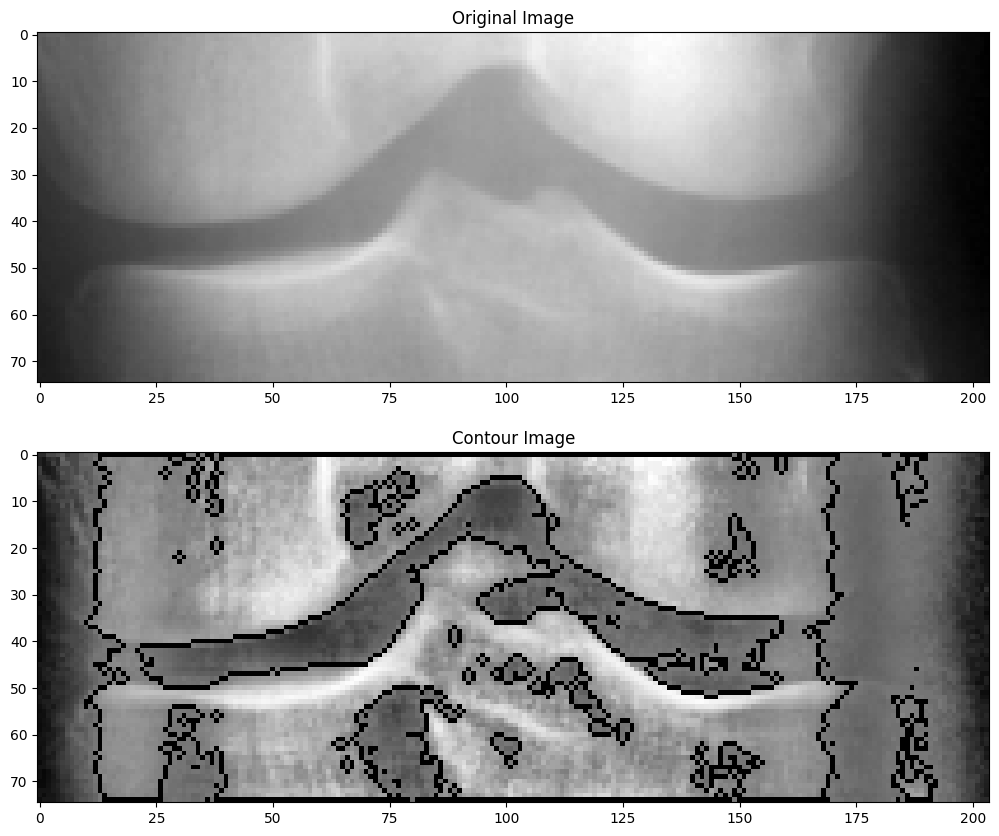

In [84]:
def find_contour(img):
    ret, thresh = cv2.threshold(img, 120, 255, 0)
    contours, hiearchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = find_contour(clahe_img(img))
contour_img = cv2.drawContours(clahe_img(img), contours, -1, (0,255,0), 1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 1, 2)
plt.imshow(contour_img, cmap='gray')
plt.title('Contour Image')
plt.show()

해리스 코너 추출(CornerHarris)

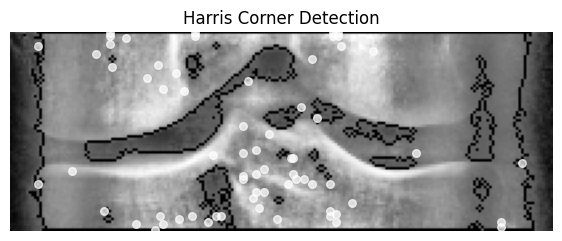

In [39]:
def harris(img):
    dst = cv2.cornerHarris(img, 2, 3, 0.24)
    return dst

# thresholding
dst = harris(img)
ret, dst = cv2.threshold(dst, 0.001 * dst.max(), 1, 0)

x,y = np.nonzero(dst)

# plt.figure(figsixe=(15,10))
# plt.subplot(1, 2, 1)
# plt.imshow(img, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

plt.figure(figsize=(7,7))
plt.imshow(contour_img, cmap='gray')
plt.title('Harris Corner Detection')
plt.axis('off')
plt.scatter(y, x, s=30, c="w", alpha=0.7)
plt.show()

In [40]:
?cv2.cornerHarris

Docstring:
cornerHarris(src, blockSize, ksize, k[, dst[, borderType]]) -> dst
.   @brief Harris corner detector.
.   
.   The function runs the Harris corner detector on the image. Similarly to cornerMinEigenVal and
.   cornerEigenValsAndVecs , for each pixel \f$(x, y)\f$ it calculates a \f$2\times2\f$ gradient covariance
.   matrix \f$M^{(x,y)}\f$ over a \f$\texttt{blockSize} \times \texttt{blockSize}\f$ neighborhood. Then, it
.   computes the following characteristic:
.   
.   \f[\texttt{dst} (x,y) =  \mathrm{det} M^{(x,y)} - k  \cdot \left ( \mathrm{tr} M^{(x,y)} \right )^2\f]
.   
.   Corners in the image can be found as the local maxima of this response map.
.   
.   @param src Input single-channel 8-bit or floating-point image.
.   @param dst Image to store the Harris detector responses. It has the type CV_32FC1 and the same
.   size as src .
.   @param blockSize Neighborhood size (see the details on #cornerEigenValsAndVecs ).
.   @param ksize Aperture parameter for the Sobel ope